# Domain Adaptation in Computer Vision

This notebook aims to prove if Domain Adaptation, specifically CORAL Loss, is effective at improving CNN accuracy.

Paper found here: https://drive.google.com/file/d/16Gz5mhpFM9PfxREZWrYSjC4fnOsGTwbf/view?usp=sharing

 This project uses the Office-31 dataset, shortened down from 35 classes to 7 classes to reduce operations

## Office-31 Dataset:
 This dataset is comprised of 35 classes of objects and images taken through 3 different cameras: Webcam, DSLR, Amazon. These cameras vary in focus, haze, saturation, creating randomized errors that reflect real world Convolutional Neural Networks (CNN) applications.

 This project uses DSLR for training and Webcam for validation, testing the ability of the ResNet18 model to detect generalized, domain-invariant features which exist among all samples, through being exposed to an object, seen through the lens of a faulty camera, to a better quality camera.



# 1. Train Control ResNet-18

This code segment will train a control ResNet-18 Model that uses weights from ImageNet weights. The model is trained on the DSLR domain, where objects are captured through the lens on DSLR, and then tested on Webcam domain

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained ResNet18 model (using tf.keras.applications)
def create_resnet18_model(input_shape=(224, 224, 3), num_classes=10):
    # Use the ResNet50V2 implementation to simulate ResNet18
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Adding the custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the layers of ResNet50V2 (simulating ResNet18) for transfer learning
    for layer in base_model.layers:
        layer.trainable = False
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load the first 10 classes from the source domain (DSLR)
train_generator = train_datagen.flow_from_directory(
    'Office-31/dslr',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    classes=['back_pack','bike','bike_helmet','bookcase','bottle','calculator','desk_chair','desk_lamp','desktop_computer','file_cabinet']  # Assuming classes are labeled as '0' to '9'
)

val_generator = train_datagen.flow_from_directory(
    'Office-31/dslr',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    classes=['back_pack','bike','bike_helmet','bookcase','bottle','calculator','desk_chair','desk_lamp','desktop_computer','file_cabinet']
)

# Instantiate and train the ResNet18 model
with tf.device("/GPU:0"):
    model = create_resnet18_model(num_classes=10)
    history = model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate on Webcam domain (first 10 classes)
webcam_datagen = ImageDataGenerator(rescale=1./255)
webcam_generator = webcam_datagen.flow_from_directory(
    'Office-31/webcam',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    classes=['back_pack','bike','bike_helmet','bookcase','bottle','calculator','desk_chair','desk_lamp','desktop_computer','file_cabinet']
)
with tf.device("/GPU:0"):
    evaluation = model.evaluate(webcam_generator)
    print(f"Webcam domain accuracy: {evaluation[1] * 100:.2f}%")


Found 127 images belonging to 10 classes.
Found 27 images belonging to 10 classes.
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.2255 - loss: 2.5302 - val_accuracy: 0.8519 - val_loss: 1.2959
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9162 - loss: 0.3991 - val_accuracy: 0.8889 - val_loss: 0.8839
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9737 - loss: 0.0631 - val_accuracy: 0.9259 - val_loss: 0.3255
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 0.9630 - val_loss: 0.0923
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9948 - loss: 0.0183 - val_accuracy: 1.0000 - val_loss: 0.0331
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9895 - loss: 0.0171 - val_accuracy: 1.0000 - val_loss: 0.0152
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0125
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 1.0000 - loss: 1.4144e-04 - val_accuracy: 1.0000 - val_loss: 0.0133
Epoch 9/10
2/2 ━━━━━━━

# 2. Data Analysis on Control ResNet-18
We will extract precision, recall and F1 scores per class

In [2]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Get predictions
y_pred = model.predict(webcam_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification

# Extract true labels from the generator
y_true = webcam_generator.classes  # Assuming the generator contains true labels

# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_true, y_pred_classes, average=None)
recall_per_class = recall_score(y_true, y_pred_classes, average=None)
f1_per_class = f1_score(y_true, y_pred_classes, average=None)


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


In [17]:
precision_per_class

array([0.10344828, 0.04761905, 0.14285714, 0.16666667, 0.0625    ,
       0.19354839, 0.22222222, 0.07692308, 0.04761905, 0.10526316])

In [18]:
recall_per_class

array([0.10344828, 0.04761905, 0.14285714, 0.16666667, 0.0625    ,
       0.19354839, 0.25      , 0.05555556, 0.04761905, 0.10526316])

In [19]:
f1_per_class

array([0.10344828, 0.04761905, 0.14285714, 0.16666667, 0.0625    ,
       0.19354839, 0.23529412, 0.06451613, 0.04761905, 0.10526316])

## Download Precision, Recall and F1 to local

In [3]:
import pandas as pd

df=pd.DataFrame({
    "precision":precision_per_class,
    "recall":recall_per_class,
    "f1":f1_per_class,
    "categories":['back_pack','bike','bike_helmet','bookcase','bottle','calculator','desk_chair','desk_lamp','desktop_computer','file_cabinet']
})

In [4]:
df.set_index("categories")

,precision,recall,f1
categories,,,
back_pack,0.058824,0.058824,0.058824
bike,0.117647,0.117647,0.117647
bike_helmet,0.176471,0.176471,0.176471
bookcase,0.166667,0.166667,0.166667
bottle,0.062500,0.062500,0.062500
calculator,0.176471,0.176471,0.176471
desk_chair,0.117647,0.117647,0.117647
desk_lamp,0.055556,0.055556,0.055556
desktop_computer,0.142857,0.142857,0.142857


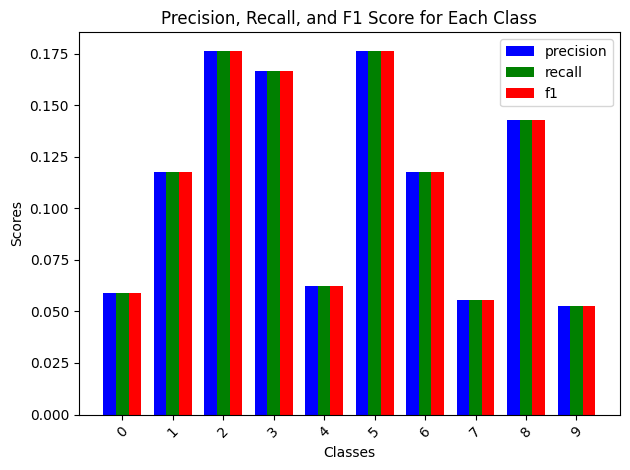

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define the width of the bars
bar_width = 0.25

# Set the x locations for the groups
x = np.arange(len(df.index))

# Create bar plots
plt.bar(x - bar_width, df['precision'], width=bar_width, label='precision', color='b')
plt.bar(x, df['recall'], width=bar_width, label='recall', color='g')
plt.bar(x + bar_width, df['f1'], width=bar_width, label='f1', color='r')

# Adding labels and title
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1 Score for Each Class')
plt.xticks(x, df.index, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [25]:
df.to_csv("Control - P,R,F.csv")

# 3. Define CORAL Loss

CORAL (CORrelation ALignment) Loss is defined as the distance between the covariance matrices of the source and target feature embeddings. These embeddings are extracted from intermediate layers of the network. The objective is to minimize domain shift by reducing the discrepancy between the second-order statistics (i.e., covariances) of the source and target domains. In the context of the altered ResNet-18, CORAL loss encourages the network to learn features that are domain-invariant, hence aligning the distributions of the source and target embeddings on a multidimensional plane.

The formula is given for Coral:

$$
\mathcal{L}_{\text{CORAL}} = \frac{1}{4d^2} \left\| C_S - C_T \right\|_F^2
$$

where $ \left\|\right\|_F $ represent the Frobenius norm.

The Frobenius norm, represented by:

$$
\| A \|_F = \sqrt{ \sum_{i=1}^{m} \sum_{j=1}^{n} |a_{ij}|^2 }
$$

Calculates the distance between two covariance embeddings between the matrices

In order to calculate second-order statistics (covariances):

$$
C = \frac{1}{n - 1} X^\top X - \frac{1}{n(n - 1)} X^\top \mathbf{1} \mathbf{1}^\top X
$$

$$
\begin{aligned}
X &\in \mathbb{R}^{n \times d} \quad &\text{Feature matrix (}n\text{ samples, }d\text{ features)} \\
\mathbf{1} &\in \mathbb{R}^{n \times 1} \quad &\text{Vector of all ones} \\
X^\top &\in \mathbb{R}^{d \times n} \quad &\text{Transpose of }X \\
C &\in \mathbb{R}^{d \times d} \quad &\text{Covariance matrix} \\
n &\in \mathbb{N} \quad &\text{Number of samples in the batch}
\end{aligned}
$$

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

total_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

# Define CORAL loss function
def coral_loss(source, target):
    d = tf.cast(tf.shape(source)[1], tf.float32)
    
    # Centering the data
    source_centered = source - tf.reduce_mean(source, axis=0)
    target_centered = target - tf.reduce_mean(target, axis=0)
    
    # Covariance matrices
    source_cov = tf.matmul(tf.transpose(source_centered), source_centered) / (tf.cast(tf.shape(source)[0], tf.float32) - 1)
    target_cov = tf.matmul(tf.transpose(target_centered), target_centered) / (tf.cast(tf.shape(target)[0], tf.float32) - 1)
    
    # CORAL loss is the Frobenius norm of the difference between covariance matrices
    loss = tf.reduce_sum(tf.square(source_cov - target_cov)) / (4 * d * d)
    return loss

Loading source training data...
Found 127 images belonging to 10 classes.
Loading target training data...
Found 235 images belonging to 10 classes.
Loading validation data...
Found 27 images belonging to 10 classes.
Creating ResNet18-like model from ResNet50...
Freezing layers...
Starting training...
Iterations per epoch: 2

Starting Epoch 1/10...
Processing Batch 1/2...
Source forward pass complete for Batch 1


KeyboardInterrupt: 

# 4. Custom ResNet-18 model with added CORAL Loss function

The model outputs both feature representations and class predictions, making this suitable for seamless CORAL Loss integration

In [ ]:

# Custom ResNet18 model that includes the additional CORAL loss
def create_coral_resnet18_model(input_shape=(224, 224, 3), num_classes=10):
    print("Creating ResNet18-like model from ResNet50...")
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Feature extractor layer (Global Average Pooling)
    feature_extractor = GlobalAveragePooling2D()(base_model.output)
    
    # Classification head
    classifier = Dense(512, activation='relu')(feature_extractor)
    predictions = Dense(num_classes, activation='softmax')(classifier)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=[feature_extractor, predictions])
    
    # Freeze base layers
    print("Freezing layers...")
    for layer in base_model.layers[:-100]:
        layer.trainable = False
    
    return model

# 5. Custom Training Loop with CORAL Loss

This code defines a **custom training loop** for training a model with the **CORAL loss** (Correlation Alignment Loss). The training loop includes both training and validation phases, where the model is trained on both source and target domain data, while aligning feature representations between them via CORAL loss. Here's a breakdown of the code:

## 1. Function Definition
```python
def train_coral_model(source_data, target_data, model, val_data, epochs=10):
```

## Inputs

### `source_data`
- **Type**: Tuple of (images, labels)
- **Description**: The training data from the source domain. This includes images and corresponding labels. It is used for training the model to learn from a known dataset.
  
### `target_data`
- **Type**: Tuple of (images)
- **Description**: The training data from the target domain. This includes only images and no labels. The goal is to align the features from the target domain with those of the source domain using the CORAL loss.

### `model`
- **Type**: TensorFlow/Keras model
- **Description**: The neural network model to be trained. This model can be a deep learning architecture such as ResNet or a custom-built model, which will use both source and target domain data during training.

### `val_data`
- **Type**: Tuple of (images, labels)
- **Description**: The validation data to monitor the model's performance after each epoch. It contains images and corresponding labels, used to calculate validation loss and accuracy.

### `epochs`
- **Type**: Integer
- **Default**: 10
- **Description**: The number of epochs to train the model. Each epoch corresponds to one full pass through the source and target training datasets. The more epochs, the more the model is trained, but it may also increase the risk of overfitting.

# For Each Batch:

## Forward Pass:
The model computes feature and predictions on the source domain and target domain

#### Loss Calculation:
#### The model calculates 2 losses:

+ Categorical Cross Entropy between true and predicted labels

+ CORAL Loss, which is used for backpropagation. The CORAL Loss uses the covariance matrices extracted from the intermediate layers of the ResNet-18

+ Total loss, summing up Categorical Cross Entropy and CORAL



Gradients of the total loss with respect to the model's tunable variables are backpropagated using ```GradientTape```


In [ ]:

# Custom training loop to incorporate CORAL loss
def train_coral_model(source_data, target_data, model, val_data, epochs=10):
    optimizer = Adam()
    train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
    val_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
    
    # Calculate the number of iterations based on the shortest dataset
    iterations_per_epoch = min(len(source_data), len(target_data))
    print(f'Iterations per epoch: {iterations_per_epoch}')
    
    for epoch in range(epochs):
        print(f'\nStarting Epoch {epoch+1}/{epochs}...')
        epoch_losses = []
        epoch_accuracies = []
        
        # Training phase
        start_time = time.time()
        for batch_num, ((source_images, source_labels), target_images) in enumerate(zip(source_data, target_data), start=1):
            if batch_num > iterations_per_epoch:
                break  # Ensure only the correct number of batches are processed
            
            print(f'Processing Batch {batch_num}/{iterations_per_epoch}...')
            batch_start_time = time.time()
            
            with tf.GradientTape() as tape:
                # Forward pass for source domain
                source_features, source_preds = model(source_images, training=True)
                print(f'Source forward pass complete for Batch {batch_num}')
                
                # Forward pass for target domain
                target_features, _ = model(target_images, training=True)
                print(f'Target forward pass complete for Batch {batch_num}')
                
                # Compute cross-entropy loss on source domain
                classification_loss = tf.keras.losses.categorical_crossentropy(source_labels, source_preds)
                
                # Compute CORAL loss to align features
                coral_loss_value = coral_loss(source_features, target_features)
                
                # Total loss
                total_loss = tf.reduce_mean(classification_loss) + coral_loss_value
                
                # Backpropagation
                gradients = tape.gradient(total_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                
                # Track loss
                epoch_losses.append(total_loss.numpy())
                
                # Update accuracy metric
                train_accuracy_metric.update_state(source_labels, source_preds)
            
            batch_end_time = time.time()
            print(f'Batch {batch_num} processed in {batch_end_time - batch_start_time:.2f} seconds')
        
        # Calculate mean accuracy for the epoch
        epoch_accuracy = train_accuracy_metric.result().numpy()
        train_accuracy_list.append(epoch_accuracy)
        train_accuracy_metric.reset_state()
        
        # Calculate mean loss for the epoch
        epoch_loss = np.mean(epoch_losses)
        total_loss_list.append(epoch_loss)
        
        # Validation phase
        val_losses = []
        val_accuracies = []
        print('Starting validation phase...')
        val_start_time = time.time()
        for val_batch_num, (val_images, val_labels) in enumerate(val_data, start=1):
            val_features, val_preds = model(val_images, training=False)
            val_classification_loss = tf.keras.losses.categorical_crossentropy(val_labels, val_preds)
            val_loss = tf.reduce_mean(val_classification_loss).numpy()
            val_losses.append(val_loss)
            
            # Update accuracy metric
            val_accuracy_metric.update_state(val_labels, val_preds)
        
        # Calculate mean validation loss and accuracy
        val_accuracy = val_accuracy_metric.result().numpy()
        val_loss_mean = np.mean(val_losses)
        val_loss_list.append(val_loss_mean)
        val_accuracy_list.append(val_accuracy)
        val_accuracy_metric.reset_state()
        
        val_end_time = time.time()
        
        # Print epoch results
        epoch_duration = time.time() - start_time
        print(f'Epoch {epoch+1} - Training Loss: {epoch_loss} - Training Accuracy: {epoch_accuracy}')
        print(f'Validation Loss: {val_loss_mean} - Validation Accuracy: {val_accuracy}')
        print(f'Epoch Duration: {epoch_duration:.2f} seconds (Validation took {val_end_time - val_start_time:.2f} seconds)')
    
    return total_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

In [ ]:

# Load the data using ImageDataGenerator for both DSLR (source) and Webcam (target)
source_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
target_datagen = ImageDataGenerator(rescale=1./255)

# Load images from DSLR domain (source domain) with only the first 10 classes
print('Loading source training data...')
source_train_gen = source_datagen.flow_from_directory(
    'Office-31/dslr',  # DSLR domain directory
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    classes=['back_pack','bike','bike_helmet','bookcase','bottle','calculator','desk_chair','desk_lamp','desktop_computer','file_cabinet']
)

# Load images from Webcam domain (target domain) with only the first 10 classes
print('Loading target training data...')
target_train_gen = target_datagen.flow_from_directory(
    'Office-31/webcam',  # Webcam domain directory
    target_size=(224, 224),
    batch_size=64,
    class_mode=None,
    classes=['back_pack','bike','bike_helmet','bookcase','bottle','calculator','desk_chair','desk_lamp','desktop_computer','file_cabinet']
)

# Load validation data for source domain with only the first 10 classes
print('Loading validation data...')
source_val_gen = source_datagen.flow_from_directory(
    'Office-31/dslr',  # Adjust to your source validation data
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    classes=['back_pack','bike','bike_helmet','bookcase','bottle','calculator','desk_chair','desk_lamp','desktop_computer','file_cabinet']
)

## CORAL ResNet-18 is trained on DSLR, and target is Webcam

In [ ]:
with tf.device("/GPU:0"):
    # Instantiate and train the CORAL ResNet18 model
    coral_model = create_coral_resnet18_model(num_classes=10)
    print("Starting training...")
    total_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = train_coral_model(
        source_train_gen, target_train_gen, coral_model, source_val_gen, epochs=10
    )


In [1]:
import sklearn.metrics
model.evaluate(webcam_generator)

NameError: name 'model' is not defined

# 6. Evaluate the divergence of the Webcam and DSLR through the Kolmogorov-Smirnov Test and Jensen-Shannon Divergence

Webcam and DSLR features are extracted

+ The ResNet18 model is loaded with pre-trained weights from ImageNet.

+ The final classification layer is removed to keep only the convolutional layers for feature extraction.

+ The model is set to evaluation mode using eval().

+ Image transformations are defined (resize to 224x224, convert to tensor, and normalize using ImageNet statistics).

+ The Office-31 dataset is loaded from the "webcam" and "dslr" folders using ImageFolder and transformations are applied.

+ DataLoader objects are created for batch processing of the datasets.

+ A function ```extract_features``` is defined to pass the images through the model and extract features, which are flattened and concatenated.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms

# Load pre-trained ResNet18
resnet18 = models.resnet18(pretrained=True)

# Remove the final classification layer to get features
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])
feature_extractor.eval()

# Define transformations (resize to 224x224 and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Office-31 dataset (replace with the actual path to your dataset)
webcam_dataset = datasets.ImageFolder(root="Office-31/webcam", transform=transform)
dslr_dataset = datasets.ImageFolder(root="Office-31/dslr", transform=transform)

# Create DataLoaders for batch processing
webcam_loader = torch.utils.data.DataLoader(webcam_dataset, batch_size=32, shuffle=False)
dslr_loader = torch.utils.data.DataLoader(dslr_dataset, batch_size=32, shuffle=False)

# Function to extract features
def extract_features(loader, model):
    features = []
    with torch.no_grad():
        for inputs, _ in loader:
            output = model(inputs)
            features.append(output.view(output.size(0), -1))  # Flatten the features
    return torch.cat(features)

# Extract features for webcam and DSLR domains
webcam_features = extract_features(webcam_loader, feature_extractor).numpy()
dslr_features = extract_features(dslr_loader, feature_extractor).numpy()

print(f"Webcam features shape: {webcam_features.shape}")
print(f"DSLR features shape: {dslr_features.shape}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/adityachakraborty/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 51.2MB/s]


Webcam features shape: (235, 512)
DSLR features shape: (154, 512)


In [2]:
import scipy.stats as stats
from scipy.spatial.distance import jensenshannon

# Kolmogorov-Smirnov (KS) Test
def ks_test(webcam, dslr):
    p_values = []
    for i in range(webcam.shape[1]):
        # Perform KS test for each feature (column)
        ks_stat, p_value = stats.ks_2samp(webcam[:, i], dslr[:, i])
        p_values.append(p_value)
    return np.mean(p_values)  # Average p-value over all feature dimensions

ks_p_value = ks_test(webcam_features, dslr_features)
print(f"Kolmogorov-Smirnov Test p-value: {ks_p_value}")

# Jensen-Shannon Divergence
def js_divergence(webcam, dslr):
    js_values = []
    for i in range(webcam.shape[1]):
        # Calculate JS divergence for each feature (column)
        webcam_dist = np.histogram(webcam[:, i], bins=50, density=True)[0]
        dslr_dist = np.histogram(dslr[:, i], bins=50, density=True)[0]
        
        # Normalize the distributions to avoid NaN values
        webcam_dist /= webcam_dist.sum()
        dslr_dist /= dslr_dist.sum()
        
        # Compute the Jensen-Shannon divergence
        js_val = jensenshannon(webcam_dist, dslr_dist)
        js_values.append(js_val)
    return np.mean(js_values)  # Average JS divergence over all feature dimensions

js_div = js_divergence(webcam_features, dslr_features)
print(f"Jensen-Shannon Divergence: {js_div}")


Kolmogorov-Smirnov Test p-value: 0.2750561766887005
Jensen-Shannon Divergence: 0.2684382783804823
